**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

# Exercise 2: Benefit of BatchNorm with CIFAR10 Classification

In [1]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary
import numpy as np

In [2]:
Transform = ToTensor()

train_data = datasets.CIFAR10(
    root = "../data",
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = "../data", 
    train = False, 
    transform = Transform,
    download = True
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

n_classes = len(train_data.classes)
input_size = (train_loader.batch_size, *train_data[0][0].shape)

In [4]:
def train(epoch, model, optimizer, criterion, data_loader, log_interval=200):
    
    model.train()
    
    total_train_loss = 0
    total_correct = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)

        loss.backward()
        
        optimizer.step()
        
        total_train_loss += loss.item()
        
        pred = output.argmax(dim=1)
        
        total_correct += torch.sum(pred == target).item()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{:5}/{:5} ({:2.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

    accuracy_train = total_correct / len(data_loader.dataset)

    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [5]:
@torch.inference_mode()
def validate(model, data_loader):
   
    model.eval()
    
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        output = model(data)
        val_loss += criterion(output, target).item()
        
        pred = output.argmax(dim=1)
        total_correct += torch.sum(pred == target).item()
        total_preds.append(pred.detach().cpu())
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print("Validation set: Average loss: {:.4f}, Accuracy: {:5}/{:5} ({:2.2f}%)\n".format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

In [6]:
def train_eval_loop(optimizer, criterion, epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        train_result = train(epoch, model, optimizer, criterion, train_loader)
        train_losses.append(train_result["loss"])
        train_accuracies.append(train_result["accuracy"])

        val_result = validate(model, test_loader)
        val_losses.append(val_result["loss"])
        val_accuracies.append(val_result["accuracy"])
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [7]:
def plot_performance(ax1, ax2, train_losses, train_accuracies, val_losses, val_accuracies, suffix=""):
    color = f"C{len(ax1.lines) // 2}"

    ax1.set_title("loss")
    ax1.plot(train_losses, label=f"{suffix} train", linestyle="dashed", color=color)
    ax1.plot(val_losses, label=f"{suffix} test", color=color)
    ax1.set_xlabel("epoch")
    ax1.legend()
    ax1.grid()

    ax2.set_title("accuracy")
    ax2.plot(train_accuracies, label=f"{suffix} train", linestyle="dashed", color=color)
    ax2.plot(val_accuracies, label=f"{suffix} test", color=color)
    ax2.set_xlabel("epoch")
    ax2.legend()
    ax2.grid()
    
def create_figure_and_plot_performance(results, suffix=""):
    f = plt.figure(figsize=(16,6))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    plot_performance(ax1, ax2, *results, suffix)

In [8]:
def get_model(activation_function, batchnorm=False, dropout=False):
    model = nn.Sequential(
        nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            padding="same",
            stride=1,
        ),
        nn.BatchNorm2d(32) if batchnorm else nn.Identity(),
        activation_function(),
        nn.MaxPool2d(2),
        nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding="same",
            stride=1,
        ),
        nn.BatchNorm2d(64) if batchnorm else nn.Identity(),
        activation_function(),
        nn.MaxPool2d(2),
        nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            padding="same",
            stride=1,
        ),
        nn.BatchNorm2d(128) if batchnorm else nn.Identity(),
        activation_function(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Dropout(.2) if dropout else nn.Identity(),
        nn.Linear(32*32 * 128 // 4 // 4 // 4, 64),
        nn.BatchNorm1d(64) if batchnorm else nn.Identity(),
        activation_function(),
        nn.Dropout(.2) if dropout else nn.Identity(),
        nn.Linear(64, n_classes),
        # nn.Softmax(dim=0) # not needed when crossentropyloss is used
    )
    return model, optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

## a) base

In [9]:
model, optimizer = get_model(activation_function=nn.ReLU)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─Identity: 1-2                          [128, 32, 32, 32]         --
├─ReLU: 1-3                              [128, 32, 32, 32]         --
├─MaxPool2d: 1-4                         [128, 32, 16, 16]         --
├─Conv2d: 1-5                            [128, 64, 16, 16]         18,496
├─Identity: 1-6                          [128, 64, 16, 16]         --
├─ReLU: 1-7                              [128, 64, 16, 16]         --
├─MaxPool2d: 1-8                         [128, 64, 8, 8]           --
├─Conv2d: 1-9                            [128, 128, 8, 8]          73,856
├─Identity: 1-10                         [128, 128, 8, 8]          --
├─ReLU: 1-11                             [128, 128, 8, 8]          --
├─MaxPool2d: 1-12                        [128, 128, 4, 4]          --
├─Flat

## b) relu

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.306288
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.570907


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.3412, Accuracy:  5183/10000 (51.83%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 1.448188
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.293167


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.1619, Accuracy:  5880/10000 (58.80%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 0.870675
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.196110


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0525, Accuracy:  6287/10000 (62.87%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 0.934931
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.920513


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9938, Accuracy:  6493/10000 (64.93%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 1.033007
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.776558


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9096, Accuracy:  6815/10000 (68.15%)



Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 6 [    0/50000 ( 0%)]	Loss: 0.704647
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.826326


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8595, Accuracy:  7051/10000 (70.51%)



Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 7 [    0/50000 ( 0%)]	Loss: 0.573992
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.772998


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8245, Accuracy:  7150/10000 (71.50%)



Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 8 [    0/50000 ( 0%)]	Loss: 0.528811
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.531583


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8651, Accuracy:  7052/10000 (70.52%)



Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 9 [    0/50000 ( 0%)]	Loss: 0.847138
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.668488


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.7815, Accuracy:  7354/10000 (73.54%)



Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 10 [    0/50000 ( 0%)]	Loss: 0.726341
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.676472


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8242, Accuracy:  7228/10000 (72.28%)



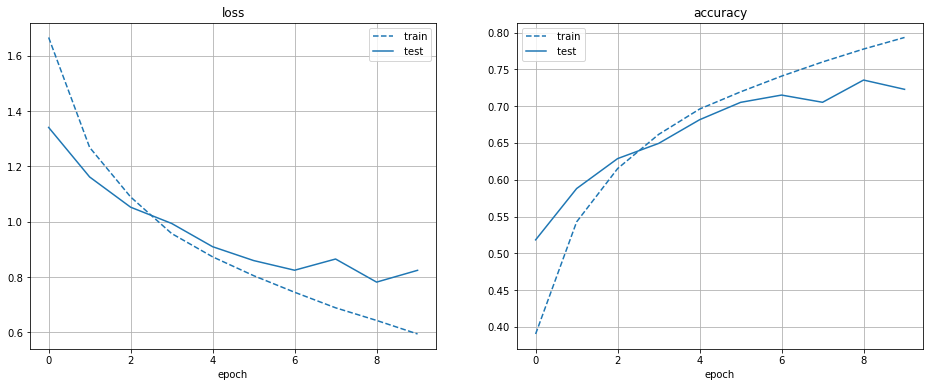

In [10]:
results_b = train_eval_loop(optimizer, criterion)
create_figure_and_plot_performance(results_b)

## c) tanh

In [11]:
model, optimizer = get_model(activation_function=nn.Tanh)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─Identity: 1-2                          [128, 32, 32, 32]         --
├─Tanh: 1-3                              [128, 32, 32, 32]         --
├─MaxPool2d: 1-4                         [128, 32, 16, 16]         --
├─Conv2d: 1-5                            [128, 64, 16, 16]         18,496
├─Identity: 1-6                          [128, 64, 16, 16]         --
├─Tanh: 1-7                              [128, 64, 16, 16]         --
├─MaxPool2d: 1-8                         [128, 64, 8, 8]           --
├─Conv2d: 1-9                            [128, 128, 8, 8]          73,856
├─Identity: 1-10                         [128, 128, 8, 8]          --
├─Tanh: 1-11                             [128, 128, 8, 8]          --
├─MaxPool2d: 1-12                        [128, 128, 4, 4]          --
├─Flat

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.300945
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.621481


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.1773, Accuracy:  5893/10000 (58.93%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 1.081043
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.932051


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0179, Accuracy:  6457/10000 (64.57%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 0.912220
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.960815


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9433, Accuracy:  6751/10000 (67.51%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 0.848275
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.874799


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9159, Accuracy:  6823/10000 (68.23%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 0.760384
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.771466


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8952, Accuracy:  6924/10000 (69.24%)



Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 6 [    0/50000 ( 0%)]	Loss: 0.665409
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.683735


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8564, Accuracy:  7095/10000 (70.95%)



Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 7 [    0/50000 ( 0%)]	Loss: 0.595122
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.489941


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8363, Accuracy:  7143/10000 (71.43%)



Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 8 [    0/50000 ( 0%)]	Loss: 0.505117
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.515214


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8385, Accuracy:  7242/10000 (72.42%)



Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 9 [    0/50000 ( 0%)]	Loss: 0.482754
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.559194


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8649, Accuracy:  7175/10000 (71.75%)



Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 10 [    0/50000 ( 0%)]	Loss: 0.434095
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.465580


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8779, Accuracy:  7182/10000 (71.82%)



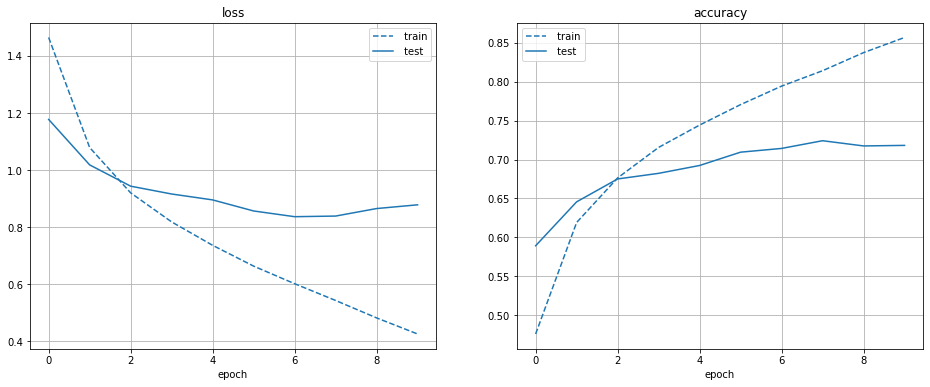

In [12]:
results_c = train_eval_loop(optimizer, criterion)
create_figure_and_plot_performance(results_c)

## d) batchnorm

In [13]:
model, optimizer = get_model(activation_function=nn.ReLU, batchnorm=True)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─BatchNorm2d: 1-2                       [128, 32, 32, 32]         64
├─ReLU: 1-3                              [128, 32, 32, 32]         --
├─MaxPool2d: 1-4                         [128, 32, 16, 16]         --
├─Conv2d: 1-5                            [128, 64, 16, 16]         18,496
├─BatchNorm2d: 1-6                       [128, 64, 16, 16]         128
├─ReLU: 1-7                              [128, 64, 16, 16]         --
├─MaxPool2d: 1-8                         [128, 64, 8, 8]           --
├─Conv2d: 1-9                            [128, 128, 8, 8]          73,856
├─BatchNorm2d: 1-10                      [128, 128, 8, 8]          256
├─ReLU: 1-11                             [128, 128, 8, 8]          --
├─MaxPool2d: 1-12                        [128, 128, 4, 4]          --
├─Fl

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.403860
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.121209


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.1009, Accuracy:  6147/10000 (61.47%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 0.827625
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.744329


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8887, Accuracy:  6868/10000 (68.68%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 0.619553
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.498031


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.7674, Accuracy:  7335/10000 (73.35%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 0.443954
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.496117


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.7869, Accuracy:  7298/10000 (72.98%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 0.520651
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.439480


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.7042, Accuracy:  7614/10000 (76.14%)



Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 6 [    0/50000 ( 0%)]	Loss: 0.253452
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.307789


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9792, Accuracy:  6933/10000 (69.33%)



Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 7 [    0/50000 ( 0%)]	Loss: 0.243581
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.266094


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.7607, Accuracy:  7603/10000 (76.03%)



Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 8 [    0/50000 ( 0%)]	Loss: 0.209327
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.243925


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8530, Accuracy:  7503/10000 (75.03%)



Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 9 [    0/50000 ( 0%)]	Loss: 0.143394
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.230457


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8983, Accuracy:  7549/10000 (75.49%)



Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 10 [    0/50000 ( 0%)]	Loss: 0.105628
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.107798


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0720, Accuracy:  7265/10000 (72.65%)



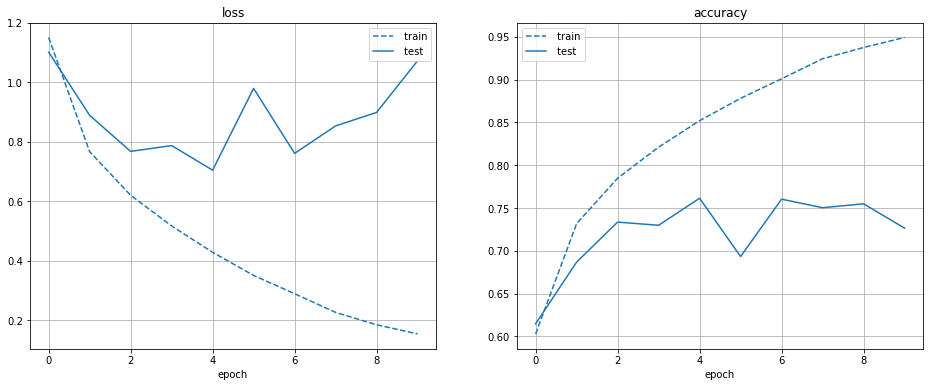

In [14]:
results_d_relu = train_eval_loop(optimizer, criterion)
create_figure_and_plot_performance(results_d_relu)

In [15]:
model, optimizer = get_model(activation_function=nn.Tanh, batchnorm=True)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─BatchNorm2d: 1-2                       [128, 32, 32, 32]         64
├─Tanh: 1-3                              [128, 32, 32, 32]         --
├─MaxPool2d: 1-4                         [128, 32, 16, 16]         --
├─Conv2d: 1-5                            [128, 64, 16, 16]         18,496
├─BatchNorm2d: 1-6                       [128, 64, 16, 16]         128
├─Tanh: 1-7                              [128, 64, 16, 16]         --
├─MaxPool2d: 1-8                         [128, 64, 8, 8]           --
├─Conv2d: 1-9                            [128, 128, 8, 8]          73,856
├─BatchNorm2d: 1-10                      [128, 128, 8, 8]          256
├─Tanh: 1-11                             [128, 128, 8, 8]          --
├─MaxPool2d: 1-12                        [128, 128, 4, 4]          --
├─Fl

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.376771
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.155148


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.2657, Accuracy:  5706/10000 (57.06%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 1.029637
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.759838


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9554, Accuracy:  6638/10000 (66.38%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 0.633369
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.834621


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8990, Accuracy:  6895/10000 (68.95%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 0.634092
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.665993


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8509, Accuracy:  7104/10000 (71.04%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 0.513426
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.606067


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8584, Accuracy:  7071/10000 (70.71%)



Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 6 [    0/50000 ( 0%)]	Loss: 0.325038
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.447880


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9552, Accuracy:  6886/10000 (68.86%)



Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 7 [    0/50000 ( 0%)]	Loss: 0.464315
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.443462


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9604, Accuracy:  6953/10000 (69.53%)



Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 8 [    0/50000 ( 0%)]	Loss: 0.293301
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.347551


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9257, Accuracy:  7069/10000 (70.69%)



Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 9 [    0/50000 ( 0%)]	Loss: 0.263513
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.293711


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9837, Accuracy:  7069/10000 (70.69%)



Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 10 [    0/50000 ( 0%)]	Loss: 0.211492
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.229307


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0164, Accuracy:  7080/10000 (70.80%)



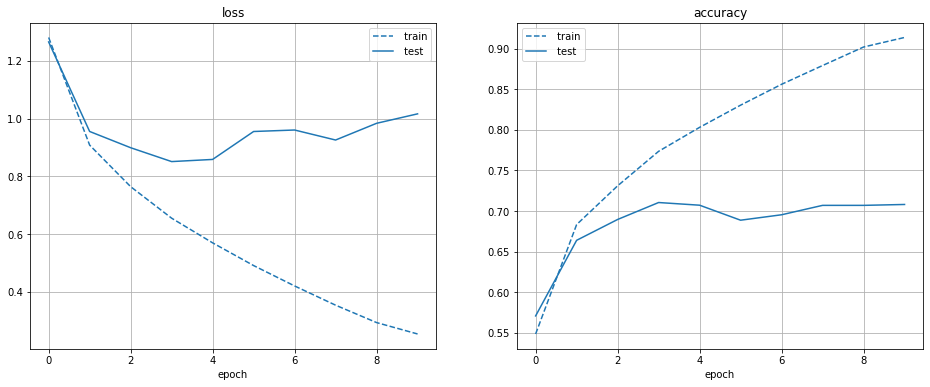

In [16]:
results_d_tanh = train_eval_loop(optimizer, criterion)
create_figure_and_plot_performance(results_d_tanh)

## e) dropout

In [17]:
model, optimizer = get_model(activation_function=nn.Tanh, dropout=True, batchnorm=False)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─Identity: 1-2                          [128, 32, 32, 32]         --
├─Tanh: 1-3                              [128, 32, 32, 32]         --
├─MaxPool2d: 1-4                         [128, 32, 16, 16]         --
├─Conv2d: 1-5                            [128, 64, 16, 16]         18,496
├─Identity: 1-6                          [128, 64, 16, 16]         --
├─Tanh: 1-7                              [128, 64, 16, 16]         --
├─MaxPool2d: 1-8                         [128, 64, 8, 8]           --
├─Conv2d: 1-9                            [128, 128, 8, 8]          73,856
├─Identity: 1-10                         [128, 128, 8, 8]          --
├─Tanh: 1-11                             [128, 128, 8, 8]          --
├─MaxPool2d: 1-12                        [128, 128, 4, 4]          --
├─Flat

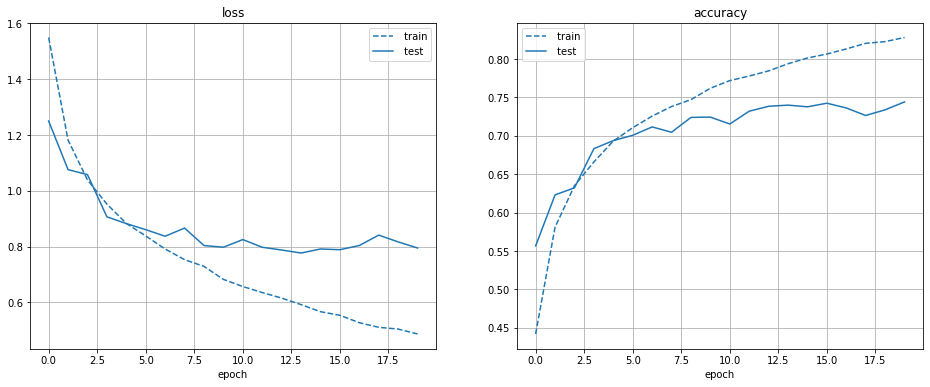

In [19]:
results_e_no_batchnorm = train_eval_loop(optimizer, criterion, epochs=20)
create_figure_and_plot_performance(results_e_no_batchnorm)

In [20]:
model, optimizer = get_model(activation_function=nn.Tanh, dropout=True, batchnorm=True)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─BatchNorm2d: 1-2                       [128, 32, 32, 32]         64
├─Tanh: 1-3                              [128, 32, 32, 32]         --
├─MaxPool2d: 1-4                         [128, 32, 16, 16]         --
├─Conv2d: 1-5                            [128, 64, 16, 16]         18,496
├─BatchNorm2d: 1-6                       [128, 64, 16, 16]         128
├─Tanh: 1-7                              [128, 64, 16, 16]         --
├─MaxPool2d: 1-8                         [128, 64, 8, 8]           --
├─Conv2d: 1-9                            [128, 128, 8, 8]          73,856
├─BatchNorm2d: 1-10                      [128, 128, 8, 8]          256
├─Tanh: 1-11                             [128, 128, 8, 8]          --
├─MaxPool2d: 1-12                        [128, 128, 4, 4]          --
├─Fl

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.379048
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.284415


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0649, Accuracy:  6248/10000 (62.48%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 0.943096
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.134343


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0237, Accuracy:  6371/10000 (63.71%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 0.949627
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.830168


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8827, Accuracy:  6910/10000 (69.10%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 0.819199
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.787131


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8621, Accuracy:  6972/10000 (69.72%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 0.801178
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.747884


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9362, Accuracy:  6717/10000 (67.17%)



Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 6 [    0/50000 ( 0%)]	Loss: 0.661470
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.699447


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8223, Accuracy:  7161/10000 (71.61%)



Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 7 [    0/50000 ( 0%)]	Loss: 0.639976
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.658354


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8561, Accuracy:  7061/10000 (70.61%)



Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 8 [    0/50000 ( 0%)]	Loss: 0.570028
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.638499


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9710, Accuracy:  6683/10000 (66.83%)



Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 9 [    0/50000 ( 0%)]	Loss: 0.471305
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.645905


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8322, Accuracy:  7139/10000 (71.39%)



Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 10 [    0/50000 ( 0%)]	Loss: 0.499621
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.664950


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.7954, Accuracy:  7288/10000 (72.88%)



Training Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 11 [    0/50000 ( 0%)]	Loss: 0.430290
Train Epoch: 11 [25600/50000 (51%)]	Loss: 0.505553


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.7633, Accuracy:  7408/10000 (74.08%)



Training Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 12 [    0/50000 ( 0%)]	Loss: 0.494879
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.526382


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.7640, Accuracy:  7414/10000 (74.14%)



Training Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 13 [    0/50000 ( 0%)]	Loss: 0.497248
Train Epoch: 13 [25600/50000 (51%)]	Loss: 0.425083


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8297, Accuracy:  7236/10000 (72.36%)



Training Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 14 [    0/50000 ( 0%)]	Loss: 0.432041
Train Epoch: 14 [25600/50000 (51%)]	Loss: 0.436695


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8332, Accuracy:  7278/10000 (72.78%)



Training Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 15 [    0/50000 ( 0%)]	Loss: 0.461403
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.539939


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0256, Accuracy:  6779/10000 (67.79%)



Training Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 16 [    0/50000 ( 0%)]	Loss: 0.316248
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.401763


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8334, Accuracy:  7350/10000 (73.50%)



Training Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 17 [    0/50000 ( 0%)]	Loss: 0.427989
Train Epoch: 17 [25600/50000 (51%)]	Loss: 0.522970


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8338, Accuracy:  7386/10000 (73.86%)



Training Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 18 [    0/50000 ( 0%)]	Loss: 0.501072
Train Epoch: 18 [25600/50000 (51%)]	Loss: 0.485506


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8388, Accuracy:  7386/10000 (73.86%)



Training Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 19 [    0/50000 ( 0%)]	Loss: 0.364804
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.425185


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8952, Accuracy:  7257/10000 (72.57%)



Training Epoch 20:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 20 [    0/50000 ( 0%)]	Loss: 0.281167
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.336997


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8433, Accuracy:  7403/10000 (74.03%)



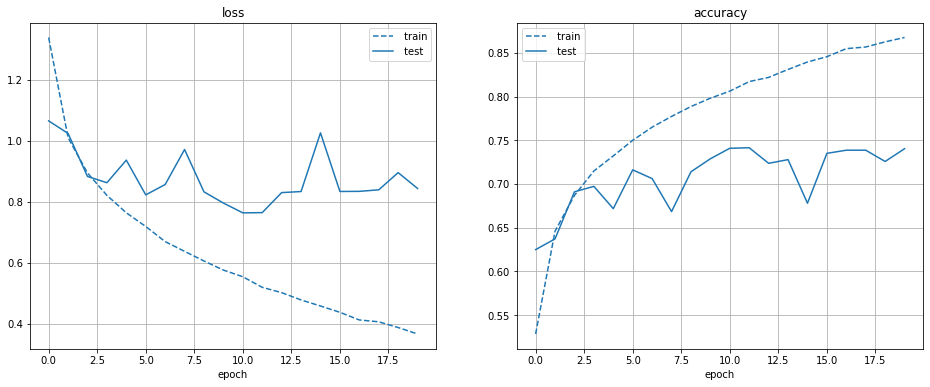

In [21]:
results_e_batchnorm = train_eval_loop(optimizer, criterion, epochs=20)
create_figure_and_plot_performance(results_e_batchnorm)

## f) comparison

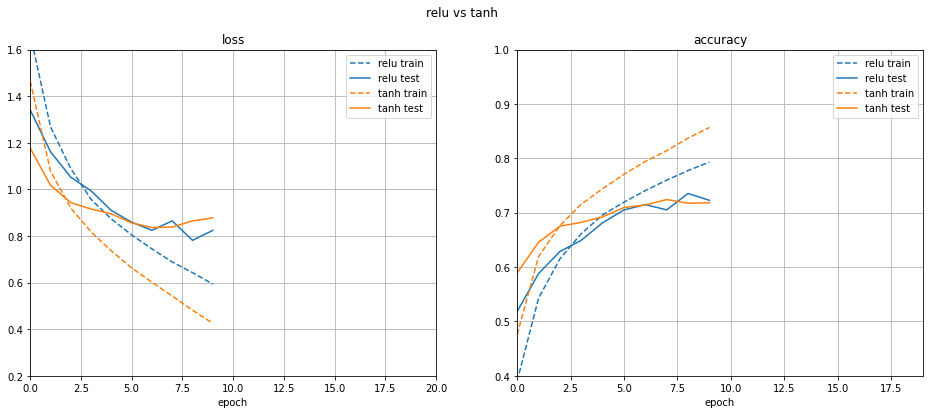

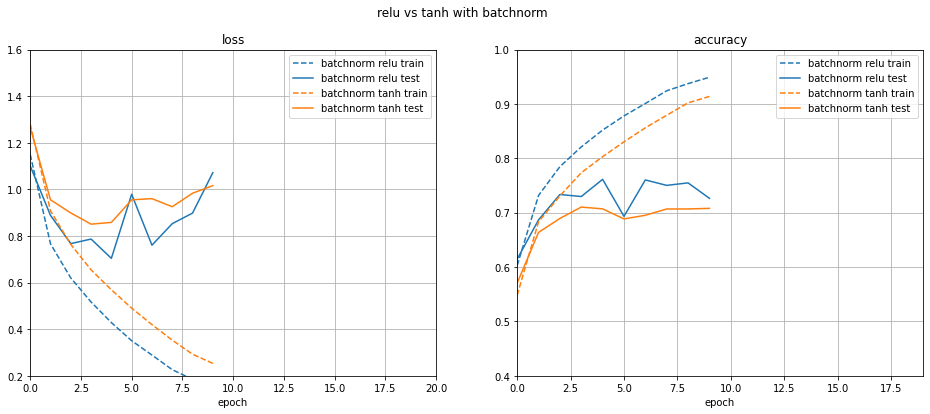

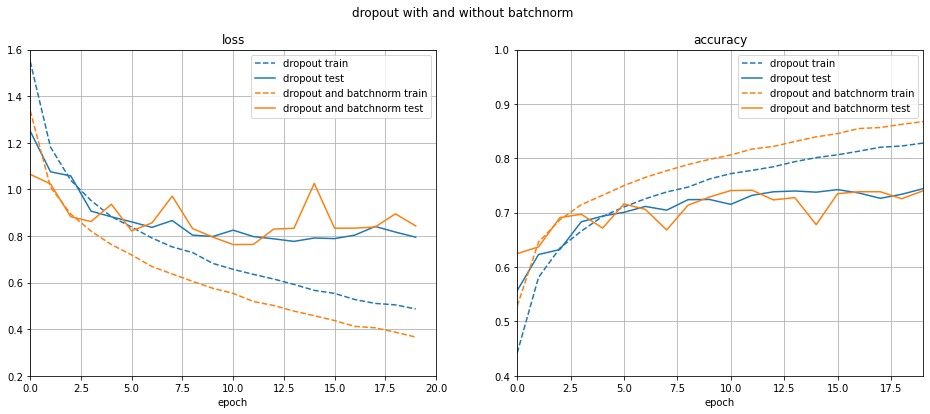

In [27]:
plot_data = [
    ("relu vs tanh",
     "relu", results_b,
     "tanh", results_c),
    ("relu vs tanh with batchnorm",
     "batchnorm relu", results_d_relu,
     "batchnorm tanh", results_d_tanh),
    ("dropout with and without batchnorm",
     "dropout", results_e_no_batchnorm,
     "dropout and batchnorm", results_e_batchnorm)
]

for pd in plot_data:
    f = plt.figure(figsize=(16,6))
    plt.suptitle(pd[0])
    ax1 = f.add_subplot(121)
    ax1.set_ylim(.2, 1.6)
    ax1.set_xlim(0, 20)
    ax1.grid()
    ax2 = f.add_subplot(122)
    ax2.set_ylim(.4, 1)
    ax2.set_xlim(0, 19)
    ax2.grid()
    plot_performance(ax1, ax2, *pd[2], pd[1])
    plot_performance(ax1, ax2, *pd[4], pd[3])